In [2]:
import numpy as np
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torcheval.metrics.functional import r2_score as r2

# Leaner code

- x and y are always small cap
- stick to order train, val, test
- tensors when possible

# Transforms
- y we transform with arcsin
- arcsin keep the zero and moderates large values

In [3]:
# define full path 
path_to_data = "/home/kim/data/aerosols/aerosol_emulation_data/"

# NP for now
x_train = np.load(path_to_data + 'X_train.npy')
y_train = np.load(path_to_data + 'y_train.npy')

x_test = np.load(path_to_data + 'X_test.npy')
y_test = np.load(path_to_data + 'y_test.npy')

x_val = np.load(path_to_data + 'X_val.npy')
y_val = np.load(path_to_data + 'y_val.npy')

# Select the correct 24 columns
# x train, val, test
x_train_24 = x_train[:, 8:]
x_val_24 = x_val[:, 8:]
x_test_24 = x_test[:, 8:]

# y train, val, test
y_train_24 = y_train[:, :24]
y_val_24 = y_val[:, :24]
y_test_24 = y_test[:, :24]

# How much has it changes between x (at t = 0)  and y (at t = 1)
y_delta_train_24 = y_train_24 - x_train_24
y_delta_val_24 = y_val_24 - x_val_24
y_delta_test_24 = y_test_24 - x_test_24

### SPECIES ###
# Define column indices for each of the components (24 column version)
so4_indices = [0, 1, 2, 3, 4]
bc_indices = [5, 6, 7, 8]
oc_indices = [9, 10, 11, 12]
du_indices = [13, 14, 15, 16]

# Define aerosol species and their corresponding indices
species_indices = {
    'so4': so4_indices,
    'bc': bc_indices,
    'oc': oc_indices,
    'du': du_indices
}

### SPLIT ###
data_split = ['train', 'val', 'test']

# What are these indices?!
extra_indices = [17, 18, 19, 20, 21, 22, 23] 

# np.set_printoptions(precision = 4, suppress = True, formatter = {'all': lambda x: f'{x:.4f}'})

In [4]:
# Global function: writes the log-normalized tensors to the global namespace
# X values are log-normalized per species
def log_normalise_x_per_species(eps = 1e-5):
    # Iterate over species
    for species, indices in species_indices.items():
        # Iterate over data splits (train, val, test)
        for split in data_split:
            # Fetch the data
            x_split_species = globals()[f'x_{split}_24'][:, indices]
            # Make tensor
            x_split_species = torch.tensor(x_split_species).clone()

            # STEP 1: Log
            # Need decent size eps to avoid log(0)
            log_split_species = torch.log(x_split_species + eps)
            # Check for finite values (no NaN or inf)
            assert torch.all(torch.isfinite(log_split_species)), f"Log transform failed for {split} {species}"

            # STEP 2: Normalize
            # Subtract mean of full species to retain differences, brackets make a difference!
            log_norm_split_species = (log_split_species - torch.mean(log_split_species)) / torch.std(log_split_species)

            # SAVE
            globals()[f'x_{split}_{species}_log_norm'] = log_norm_split_species

# Call
log_normalise_x_per_species()

In [5]:
def arcsinh_x_per_species(eps = 1e-5):
    # This transformation can be easily reversed and preserved the zero
    # Iterate over species
    for species, indices in species_indices.items():
        # Iterate over data splits (train, val, test)
        for split in data_split:
            # Fetch the data
            x_split_species = globals()[f'x_{split}_24'][:, indices]
            # Make tensor
            x_split_species = torch.tensor(x_split_species).clone()

            # STEP 1: Clamp negative values as these should not be allowed
            nonneg_split_species = torch.clamp_min(x_split_species, min = 0.0)

            # STEP 2: Arcsinh
            arcsinh_norm_split_species = torch.arcsinh(nonneg_split_species)

            # SAVE
            globals()[f'x_{split}_{species}_arcsinh'] = arcsinh_norm_split_species

# Call
arcsinh_x_per_species()

In [6]:
def arcsin_y_delta_per_species(eps = 1e-5):
    # Iterate over species
    for species, indices in species_indices.items():
        # Iterate over data splits (train, val, test)
        for split in data_split:
            # Fetch the data
            y_delta_split_species = globals()[f'y_delta_{split}_24'][:, indices]
            # Make tensor
            y_delta_split_species = torch.tensor(y_delta_split_species).clone()
            # globals()[f'y_delta_{split}_{species}'] = y_delta_split_species

            # STEP 1: scale to unit var
            y_delta_split_species_unitvar = y_delta_split_species / torch.std(y_delta_split_species)
            # globals()[f'y_delta_{split}_{species}_unitvar'] = y_delta_split_species_unitvar

            # export std to global namespace for renormalization
            globals()[f'std_y_delta_{split}_{species}'] = torch.std(y_delta_split_species)

            # STEP 2: Arcsin
            arcsinh_y_delta_split_species = torch.asinh(y_delta_split_species)
            arcsinh_unitvar_y_delta_split_species = torch.asinh(y_delta_split_species_unitvar)

            # SAVE both options
            globals()[f'y_delta_{split}_{species}_arcsinh'] = arcsinh_y_delta_split_species
            globals()[f'y_delta_{split}_{species}_arcsinh_unitvar'] = arcsinh_unitvar_y_delta_split_species

# Call
arcsin_y_delta_per_species()

In [7]:
def n_random_rows(x, n = 5000):
    """Returns n random rows from x"""
    # Default is 5000
    indices = np.random.choice(x.shape[0], n, replace = False)
    return x[indices]

def n_random_row_incides(x, n = 5000):
    """Returns n random rows from x"""
    # Default is 5000
    indices = np.random.choice(x.shape[0], n, replace = False)
    return indices

# So4 model is the crux

- needs transformation
- the other have outlier values
- Dividing by the standard deviation (or performing Z-score normalization) does not impact the property of the data summing to zero

- We can apply sinh() to transform back into OG units
- arcsinh transformation: zero is zero

In [9]:
import matplotlib.pyplot as plt
import numpy as np

row_indices = n_random_row_incides(x_train_so4_log_norm)

plt.figure(figsize=(8, 6))

for species in species_indices.keys():  # Iterate over all species
    split = 'train'
    
    x_data = globals()[f'x_{split}_{species}_log_norm'][row_indices]  # Shape: (N, 5)
    x_data = globals()[f'x_{split}_{species}'][row_indices]  # Shape: (N, 5)
    # y_data = globals()[f'y_delta_{split}_{species}_arcsinh'][row_indices]  # Shape: (N, 5)
    # Untransformed does not work for So4
    # The
    # y_data = globals()[f'y_delta_{split}_{species}'][row_indices]
    y_data = torch.arcsin(globals()[f'y_delta_{split}_{species}_arcsinh_unitvar'][row_indices])

    num_columns = x_data.shape[1]  # Should be 5
    colors = ['blue', 'green', 'red', 'purple', 'orange']

    for i in range(num_columns):
        plt.scatter(
            x_data[:, i],  
            y_data[:, i],  # Use the corresponding column in y_data
            alpha = 0.1,
            color = colors[i],
            label = f'{species} - Feature {i+1}'
        )

    plt.xlabel('log_norm(x_train)')
    plt.ylabel('arcsin(y_delta_train)')
    plt.title(f'arcsin(y_delta_train) over log_norm(x_train) for {species}')
    plt.legend()
    plt.grid(True, alpha = 0.1)

    plt.show()

KeyError: 'x_train_so4'

<Figure size 800x600 with 0 Axes>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

row_indices = n_random_row_incides(x_train_so4_log_norm)

plt.figure(figsize=(8, 6))

for species in species_indices.keys():  # Iterate over all species
    split = 'train'
    
    x_data = globals()[f'x_{split}_{species}_arcsinh_unitvar'][row_indices]  # Shape: (N, 5) for so4
    y_data = globals()[f'y_delta_{split}_{species}_arcsinh_unitvar'][row_indices]

    num_columns = x_data.shape[1]  # Should be 5
    colors = ['blue', 'green', 'red', 'purple', 'orange']

    for i in range(num_columns):
        plt.scatter(
            x_data[:, i],  
            y_data[:, i],  # Use the corresponding column in y_data
            alpha = 0.1,
            color = colors[i],
            label = f'{species} - Feature {i+1}'
        )

    plt.xlabel('log_norm(x_train)')
    plt.ylabel('arcsin(y_delta_train)')
    plt.title(f'arcsin(y_delta_train) over log_norm(x_train) for {species}')
    plt.legend()
    plt.grid(True, alpha = 0.1)

    plt.show()

NameError: name 'n_random_row_incides' is not defined

In [ ]:
# Conserving means mean zero
# Benefit of softmax output is just that we know the mean value

In [164]:
# Generate random logits
logits = torch.randn(5)  # Example with 5 classes

# Apply softmax to get probabilities
softmax_output = torch.softmax(logits, dim = 0, dtype = torch.float64)
print("Softmax Output:", softmax_output)

softmax_output = torch.arcsinh(torch.rand(5, dtype = torch.float64))

# Mean is ALWAYS 1/N
# Mean shift
# Precision error
# conservative_vector = softmax_output - (1 / len(softmax_output))
conservative_vector = softmax_output - (torch.mean(softmax_output))
print("Conservative Vector:", conservative_vector)

print(conservative_vector.mean())
torch.sinh(torch.sinh(conservative_vector)).mean()

Softmax Output: tensor([0.0486, 0.0581, 0.7120, 0.0655, 0.1158], dtype=torch.float64)
Conservative Vector: tensor([ 0.4713,  0.1130, -0.3004, -0.0759, -0.2081], dtype=torch.float64)
tensor(2.2204e-17, dtype=torch.float64)


tensor(0.0051, dtype=torch.float64)

.... Transformations kill the constraints

# Back to transition matrix

- take absolute and relative inputs

In [220]:
import torch

# Random logits with a bias toward staying in the same class
logits = torch.randn(5, 5) * 0.1  # Small values to encourage staying in the same class

# Adding a strong bias along the diagonal (encouraging self-transitions)
for i in range(5):
    logits[i, i] += 5.0  # Bias for staying in the same class

# Apply softmax to normalize and get probabilities
transition_matrix = torch.softmax(logits, dim = 1 , dtype = torch.float64)

print(transition_matrix)

tensor([[0.9734, 0.0068, 0.0060, 0.0065, 0.0072],
        [0.0070, 0.9754, 0.0058, 0.0064, 0.0055],
        [0.0062, 0.0053, 0.9764, 0.0060, 0.0061],
        [0.0067, 0.0058, 0.0088, 0.9721, 0.0066],
        [0.0057, 0.0062, 0.0067, 0.0056, 0.9758]], dtype=torch.float64)


In [225]:
# x is a vector of masses
x = torch.linspace(1, 25, 5, dtype = torch.float64).reshape(5)
print(x)
x.sum()

tensor([ 1.,  7., 13., 19., 25.], dtype=torch.float64)


tensor(65., dtype=torch.float64)

In [232]:
x_batched = torch.linspace(1, 25, 5 * 7, dtype = torch.float64).reshape(7, 5)

x_batched
x_batched_norm = x_batched / x_batched.sum(axis = -1).unsqueeze(-1)

In [235]:
x_batched_norm

torch.cat((x_batched, x_batched_norm), dim = -1).shape

torch.Size([7, 10])

In [226]:
# Transition matrix without self-transitions
T_no_diag = transition_matrix - torch.eye(transition_matrix.size(0))

# Multiply the current state by the transition matrix without diagonal
deltas1 = torch.matmul(T_no_diag, x)

deltas2 = torch.matmul(transition_matrix, x) - x

In [227]:
torch.matmul(transition_matrix, x).sum()

tensor(65.0086, dtype=torch.float64)

In [228]:
torch.mean(deltas1)

tensor(0.0017, dtype=torch.float64)

In [ ]:
print(deltas1)

print(deltas2)
deltas2.sum(-1).sum()

tensor([ 0.4043,  0.1679,  0.0022, -0.2037, -0.3621], dtype=torch.float64)
tensor([ 0.4043,  0.1679,  0.0022, -0.2037, -0.3621], dtype=torch.float64)


tensor(0.0086, dtype=torch.float64)

In [398]:
class TransitionMatrix(nn.Module):
    def __init__(self, in_features, out_features, width, depth = 2, bias = 5.0):
        super(TransitionMatrix, self).__init__()
        # this is the self transition bias, added to the logits (prior knowledge), high val
        self.bias = bias
        self.out_features = out_features
        # define this once and reuse
        self.transition_identity = torch.eye(out_features).unsqueeze(0)
        self.eps = 1e-8

        # the first layer takes in_features * 2 as input, because we are concatenating the inputthe raltive inputs
        self.fc_in = nn.Linear(in_features = in_features * 2, out_features = width)

        self.hidden_layers = nn.ModuleList()
        for _ in range(depth -1):
            self.hidden_layers.append(nn.ReLU())
            self.hidden_layers.append(nn.Linear(in_features = width, out_features = width))
            self.hidden_layers.append(nn.ReLU())

        # for the transition matrix, we want to have a square matrix, 1 for scale factor
        self.fc_out = nn.Linear(in_features = width, out_features = (out_features * out_features) + 1)

        # Set all model parameters to double precision
        self.to(torch.float64)

    def forward(self, x):
        # x is shape(batch_size, in_features)
        # ensure double
        x = x.to(torch.float64)
        
        # Normalise the input to relative values (sum to 1), clamp to avoid div by zero
        x_relative = x / torch.clamp_min(x.sum(axis = -1), self.eps).unsqueeze(-1)

        # Concatenate the input with the relative input and pass into the first layer
        # shape(batch_size, in_features * 2)
        state = self.fc_in(torch.cat((x, x_relative), dim = -1))

        for layer in self.hidden_layers:
            state = layer(state)

        state = self.fc_out(state)

        # Divide the output into logits and scale factor
        logits_raw, scale_factor = state[:, :-1], state[:, -1]

        # Reshape to get (batch_size, out_features, out_features)
        logits = logits_raw.view(-1, self.out_features, self.out_features)

        if torch.isnan(logits).any():
            print("NaN detected at logits!")
        if torch.isinf(logits).any():
            print("Inf detected at logits!")

        # Add the bias to the diagonal (self transitions) with in-place operation
        logits.diagonal(dim1 = -2, dim2 = -1).add_(self.bias)

        # Apply softmax across each row so that columns (last dim) add to 1
        # rows add to 1 (From : To): 100% of the source are redistributed
        # Variance of a softmax is 1/N, variance of a arcsinh unit std is 1
        transition_matrix = F.softmax(logits, dim = -1)

        # Transition matrix without self-transitions
        # Repeat for bacth_size
        transition_matrix_no_diag = transition_matrix - self.transition_identity.repeat(transition_matrix.shape[0], 1, 1)

        # Multiply the input by the transition matrix without diagonal: bmm or matmul work
        deltas = torch.matmul(transition_matrix_no_diag, x.unsqueeze(-1)).squeeze(-1)

        # reshape scale factor to (batch_size, 1)
        # Scale of the estimated scale factor to account for smaller variance in softmax output
        scaled_deltas = deltas * (scale_factor.unsqueeze(-1) * self.out_features)

        # correct delta numerical precision issue, but comp overhead
        corrected_scaled_deltas = scaled_deltas - scaled_deltas.mean(dim = (-1), keepdim = True)
        # print((deltas.mean(dim = (-1), keepdim = True)).shape)

        # return (batch_size, out_features)
        return corrected_scaled_deltas

In [394]:
row_indices = n_random_row_incides(x_train_so4_arcsinh, 10)

in_feat = x_train_so4_arcsinh[row_indices].shape[-1]
out_feat = y_delta_train_so4_arcsinh_unitvar[row_indices].shape[-1]

print(in_feat, out_feat)

model = TransitionMatrix(in_features = in_feat, out_features = in_feat, width = 2)

out = model(x_train_so4_arcsinh[row_indices])
out.sum(-1)

5 5


tensor([ 1.3878e-17,  5.5511e-17, -8.3267e-17, -2.7756e-17,  2.7756e-17,
         2.7756e-17,  5.5511e-17, -6.9389e-18,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64, grad_fn=<SumBackward1>)

In [399]:
model = TransitionMatrix(in_features = in_feat, out_features = in_feat, width = 2).double()

# Define loss and optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = torch.nn.MSELoss()

x_train = x_train_so4_argsinh.double()
y_train = y_delta_train_so4_arcsinh_unitvar.double()

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = 256, shuffle = True)

# Training loop
epochs = 10

# For some validation
val_row_indices = n_random_row_incides(x_val_so4_arcsinh, n = 10000)

for epoch in range(epochs):
    model.train()
    
    # Iterate over batches
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # Forward pass
        deltas = model(x_batch)
        
        # Calculate loss
        loss = criterion(deltas, y_batch)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        # print(f'Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}')

        if batch_idx % 1000 == 0:
            print(f'Epoch {epoch}, Batch {batch_idx}, Training MSE Loss (transf.): {loss.item():.4f}')

        if batch_idx % 5000 == 0:
            model.eval()
            PRED_y_delta_val_arcssinh_unitvar = model(x_val_so4_arcsinh[val_row_indices])
            # Project back by applying sinh first and then scaling
            PRED_y_delta_val_arcssinh_og = torch.sinh(PRED_y_delta_val_arcssinh_unitvar) * std_y_delta_val_so4

            print("Validation R2 Score on delta sample in transformed space:")
            print(f"{r2(PRED_y_delta_val_arcssinh, y_delta_val_so4_arcsinh_unitvar[val_row_indices]).item():.4f}")

            print("Validation R2 Score on delta sample in og space:")
            print(f"{r2(PRED_y_delta_val_arcssinh_og, y_delta_val_so4[val_row_indices]).item():.4f}")

            print("Validation MSE on delta sample in og space:")
            print(f"{criterion(PRED_y_delta_val_arcssinh_og, y_delta_val_so4[val_row_indices]).item():.4f}")

            model.train()
        
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

# torch.save(model.state_dict(), os.path.join("models", "arcsinh_transition_so4.pth"))

Epoch 0, Batch 0, Training MSE Loss (transf.): 1.8950
Validation R2 Score on delta sample in transformed space:
-0.1144
Validation R2 Score on delta sample in og space:
-1463097.9175
Validation MSE on delta sample in og space:
12527115089628262400.0000
Epoch 0, Batch 1000, Training MSE Loss (transf.): 0.0462
Epoch 0, Batch 2000, Training MSE Loss (transf.): 0.0183
Epoch 0, Batch 3000, Training MSE Loss (transf.): 0.0314
Epoch 0, Batch 4000, Training MSE Loss (transf.): 0.0262
Epoch 0, Batch 5000, Training MSE Loss (transf.): 0.0344
Validation R2 Score on delta sample in transformed space:
-0.1144
Validation R2 Score on delta sample in og space:
0.1658
Validation MSE on delta sample in og space:
1997025552315.5034
Epoch 0, Batch 6000, Training MSE Loss (transf.): 0.0244
Epoch 0, Batch 7000, Training MSE Loss (transf.): 0.0243
Epoch 0, Batch 8000, Training MSE Loss (transf.): 0.0199
Epoch 0, Batch 9000, Training MSE Loss (transf.): 0.0114
Epoch 0, Batch 10000, Training MSE Loss (transf.)

KeyboardInterrupt: 

In [400]:
val_row_indices = n_random_row_incides(x_val_so4_arcsinh, n = 10000)

PRED_y_delta_val_arcssinh = model(x_val_so4_arcsinh[val_row_indices])
print(r2(PRED_y_delta_val_arcssinh, y_delta_val_so4_arcsinh_unitvar[val_row_indices]))

tensor(0.3728, dtype=torch.float64)


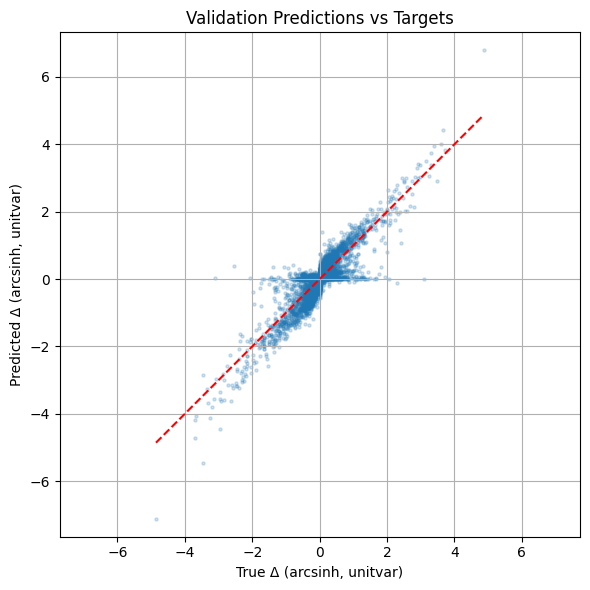

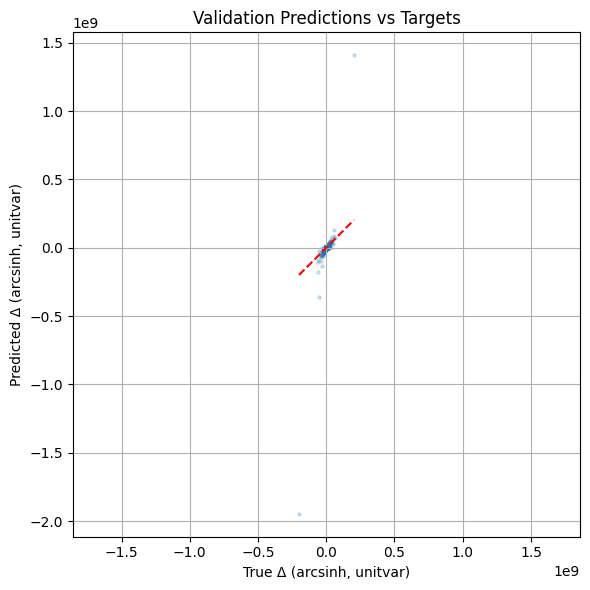

In [401]:
# Convert to numpy for plotting
y_true = y_delta_val_so4_arcsinh_unitvar[val_row_indices].cpu().numpy()
y_pred = PRED_y_delta_val_arcssinh.detach().cpu().numpy()

y_true_og = y_delta_val_so4[val_row_indices].cpu().numpy()
y_pred_og = torch.sinh(PRED_y_delta_val_arcssinh).detach().cpu().numpy() * std_y_delta_val_so4.cpu().numpy()

# Flatten for 1D comparison
y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

y_true_og_flat = y_true_og.flatten()
y_pred_og_flat = y_pred_og.flatten()

plt.figure(figsize = (6, 6))
plt.scatter(y_true_flat, y_pred_flat, alpha=0.2, s=5)
plt.plot([y_true_flat.min(), y_true_flat.max()], [y_true_flat.min(), y_true_flat.max()], 'r--')  # ideal line
plt.xlabel('True Δ (arcsinh, unitvar)')
plt.ylabel('Predicted Δ (arcsinh, unitvar)')
plt.title('Validation Predictions vs Targets')
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()

plt.figure(figsize = (6, 6))
plt.scatter(y_true_og_flat, y_pred_og_flat, alpha=0.2, s=5)
plt.plot([y_true_og_flat.min(), y_true_og_flat.max()], [y_true_og_flat.min(), y_true_og_flat.max()], 'r--')  # ideal line
plt.xlabel('True Δ (arcsinh, unitvar)')
plt.ylabel('Predicted Δ (arcsinh, unitvar)')
plt.title('Validation Predictions vs Targets')
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
PRED_y_delta_val_arcssinh.std()
y_delta_val_so4_arcsinh_unitvar[val_row_indices].mean()

PRED_y_delta_val_arcssinh_og = torch.sinh(PRED_y_delta_val_arcssinh_unitvar) * std_y_delta_val_so4

            print("Validation R2 Score on delta sample in transformed space:")
            print(f"{r2(PRED_y_delta_val_arcssinh_unitvar, y_delta_val_so4_arcsinh_unitvar[val_row_indices]).item():.4f}")

            print("Validation RMSE on delta sample in transformed space:")
            print(f"{torch.sqrt(criterion(PRED_y_delta_val_arcssinh_unitvar, y_delta_val_so4[val_row_indices])).item():.4f}")

            print("Validation R2 Score on delta sample in og space:")
            print(f"{r2(PRED_y_delta_val_arcssinh_og, y_delta_val_so4[val_row_indices]).item():.4f}")

            print("Validation RMSE on delta sample in og space:")
            print(f"{torch.sqrt(criterion(PRED_y_delta_val_arcssinh_og, y_delta_val_so4[val_row_indices])).item():.4f}")

tensor(0.0009, dtype=torch.float64)